In [1]:
#default_exp pv

# Charging with PV Forecast

Previously, we tried to produce a charge profile by constructing optimal charge profiles for each day, and then using these optimal charge profiles as targets in our models.

Here we will try and predict the optimal charge profile by first forecasting PV, then constructing an optimal profile based on the forecast. The hope is that estimating solar PV is easier than estimating optimal charge profiles, which tend to be pretty spiky and have given us weird residuals. 

### Imports

In [1]:
#exports
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from moepy.lowess import quantile_model

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GroupKFold


from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from skopt.plots import plot_objective
from skopt.space import Real, Categorical, Integer

from batopt import clean, discharge, utils, charge

import FEAutils as hlp

from ipypb import track

### User inputs

In [2]:
raw_data_dir = '../data/raw'
intermediate_data_dir = '../data/intermediate'
cache_data_dir = '../data/nb-cache'
charge_opt_model_fp = '../models/charge_opt.sav'

### Preparing data

In [3]:
#exports
def prepare_training_input_data(intermediate_data_dir, start_hour=5):
    # Loading input data
    df = clean.combine_training_datasets(intermediate_data_dir).interpolate(limit=1)
    df_features = charge.construct_df_charge_features(df)
    
    # Filtering for overlapping feature and target data
    dt_idx = pd.date_range(df_features.index.min(), df['pv_power_mw'].dropna().index.max()-pd.Timedelta(minutes=30), freq='30T')

    s_pv = df.loc[dt_idx, 'pv_power_mw']
    df_features = df_features.loc[dt_idx]
        
    # Filtering for evening datetimes
    charging_datetimes = charge.extract_charging_datetimes(df_features, start_hour=start_hour)
    
    X = df_features.loc[charging_datetimes]
    y = s_pv.loc[charging_datetimes]
    
    return X, y

### Fitting forecast model

We will quickly fit a PV model just to check the residuals and that the data is all fine:

In [4]:
X, y = prepare_training_input_data(intermediate_data_dir)

In [5]:
df_pred = clean.generate_kfold_preds(X.values, y.values, LinearRegression(), index=X.index)

Analysing residuals

Text(0, 0.5, 'Prediction')

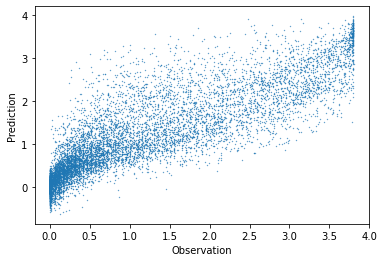

In [6]:
plt.scatter(df_pred.true, df_pred.pred, s=0.1)
plt.xlabel('Observation')
plt.ylabel('Prediction')

### Analysing random days

In [7]:
#exports
def plot_random_day(df_pred, ax=None):
    """
    View predicted and observed PV profiles
    """
    if ax is None:
        ax = plt.gca()
    
    random_day = pd.to_datetime(np.random.choice(df_pred.index.date))
    random_day = df_pred[df_pred.index.date==random_day]
    plt.plot(random_day.true)
    plt.plot(random_day.pred)
    
    return ax

<AxesSubplot:>

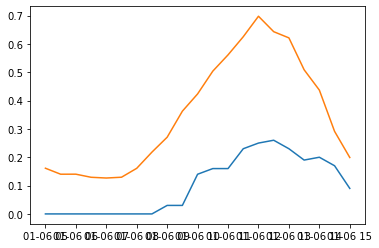

In [8]:
plot_random_day(df_pred)

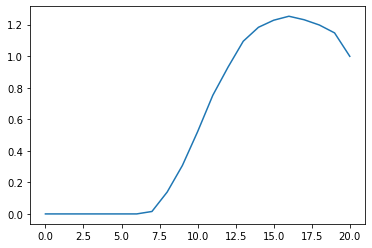

In [9]:
random_solar_profile = discharge.sample_random_day(df_pred.pred).pipe(charge.extract_solar_profile)
adj_random_solar_profile = discharge.flatten_peak(random_solar_profile)
charge_profile = charge.construct_charge_profile(random_solar_profile, adj_random_solar_profile)
plt.plot(charge_profile)

### Predicting charge based on PV forecast

Now we will begin developing a unified approach for predicting PV and then optimising the battery charge schedule. 

We will also group by week. This should make the problem a bit harder, and help encourage the final model to generalise to lengthy unseen periods.

In [10]:
#exports
def generate_kfold_preds_weeks(X, y, model, groups, kfold_kwargs, index=None):
    """
    Generate kfold preds, grouping by week
    """
    
    group_kfold = GroupKFold(**kfold_kwargs)
    
    df_pred = pd.DataFrame(columns=['pred', 'true'], index=np.arange(X.shape[0]))

    for train_index, test_index in group_kfold.split(X, y, groups):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)

        df_pred.loc[test_index, 'true'] = y_test
        df_pred.loc[test_index, 'pred'] = model.predict(X_test)

    df_pred.sort_index()

    if index is not None:
        assert len(index) == df_pred.shape[0], 'The passed index must be the same length as X and y'
        df_pred.index = index

    return df_pred
    

In [11]:
#exports
def generate_kfold_charge_preds(X, y, model, groups, kfold_kwargs={'n_splits': 5}):
    """
    Fit the PV forecasting model and calculate the optimal charge profile for predictions.
    """
    df_pred = generate_kfold_preds_weeks(X.values, y.values, model, groups, kfold_kwargs=kfold_kwargs, index=X.index)
    charge_pred = charge.construct_charge_s(df_pred.pred)
    charge_pred = charge.post_pred_charge_proc_func(charge_pred)
    return pd.DataFrame({'charge_pred': charge_pred, 
                         'pv_actual': df_pred.true,
                         'pv_pred': df_pred.pred})


In [12]:
#exports
def predict_charge(X, model):
    """
    Given a fitted PV forecast model and feature array X, get the optimal charge profile. 
    """
    pv_pred = pd.Series(model.predict(X), index=X.index)
    charge_pred = charge.construct_charge_s(pv_pred)
    charge_pred = charge.post_pred_charge_proc_func(charge_pred)
    return pd.Series(charge_pred, index=X.index)

### Holding out final month

In [13]:
def get_train_test(arr, start_of_test_period): 
    train_arr = arr[:pd.to_datetime(start_of_test_period, utc=True)]
    test_arr = arr[pd.to_datetime(start_of_test_period, utc=True):]
    
    return train_arr, test_arr

start_of_test_period = '2019-02-04'

X_train, X_test = get_train_test(X, start_of_test_period)
y_train, y_test = get_train_test(y, start_of_test_period)

### Fitting some models

Now let's try executing this unified approach using k-fold CV, for 3 default models on the training data:

In [14]:
models = {
    'std_linear': LinearRegression(),
    'lasso': Lasso(),
    'ridge': Ridge(),
    'boosted': GradientBoostingRegressor(),
    'random_forest': RandomForestRegressor(),
}

# Define the week groups
week_groups = X_train.index.year + X_train.index.isocalendar().week/52

for key in models:
    charge_pred_df = generate_kfold_charge_preds(X_train, y_train, models[key], week_groups)
    score = charge.score_charging(charge_pred_df.charge_pred, charge_pred_df.pv_actual)
    pv_mse = np.mean(np.square(charge_pred_df.pv_actual - charge_pred_df.pv_pred))
    solar_exploit_pct = 100*charge.prop_max_solar(charge_pred_df.charge_pred, charge_pred_df.pv_actual)
    print("{}: PV MSE: {:.2f}, score: {:.2f}, solar exploit: {:.2f}%".format(key, pv_mse, score, solar_exploit_pct))

std_linear: PV MSE: 0.34, score: 0.77, solar exploit: 94.52%
lasso: PV MSE: 0.37, score: 0.76, solar exploit: 93.92%
ridge: PV MSE: 0.34, score: 0.77, solar exploit: 94.52%
boosted: PV MSE: 0.35, score: 0.77, solar exploit: 94.43%
random_forest: PV MSE: 0.35, score: 0.76, solar exploit: 94.23%


Interestingly, there is little difference between the models in terms of solar exploit, even though there are some differences in the MSE of the PV forecasts. For our previous attempt at the charging task, the linear model was much worse than the boosted model and RF in terms of solar exploit. This suggests that a weak (or under-fitted) estimator of solar PV actually performs quite well when it comes to 

In [20]:
best_model = LinearRegression()
best_model.fit(X_train, y_train)
preds = predict_charge(X_test, best_model)

In [21]:
100*charge.prop_max_solar(preds, y_test)

93.49859755241243

In [17]:
list(zip(X_train.columns, 1e6*best_model.coef_))

[('temp_location1', 375673.7531223633),
 ('temp_location2', -50066.44491796433),
 ('temp_location3', -357845.6718411661),
 ('temp_location4', 205471.1821922578),
 ('temp_location5', 41687.629281235415),
 ('temp_location6', 304825.0842163973),
 ('pv_7d_lag', -27238.768187513557),
 ('solar_location2', -281.52527501453784),
 ('solar_location3', -754.3245176233611),
 ('solar_location5', 2185.9343577677605),
 ('solar_location6', -2.088445577931653),
 ('sin_hour', -106055.02740759584),
 ('cos_hour', 28629.491253707267),
 ('sin_doy', -67984.80599880702),
 ('cos_doy', 95368.51881853498),
 ('solar_location2_rolling', 1656.2935787639071),
 ('solar_location3_rolling', 2081.3730684421125),
 ('solar_location5_rolling', -1850.9548371410785),
 ('solar_location6_rolling', 1523.7054912533808),
 ('temp_location1_rolling', -275543.73655559757),
 ('temp_location2_rolling', -38183.73967443852),
 ('temp_location3_rolling', 322702.23158091883),
 ('temp_location4_rolling', -193758.75090556697),
 ('temp_locati

Running the above analysis it seems like solar_locations 1 and 4 do not contribute much at all to the regression models: both are over an order of magnitude smaller than the others. Best to remove these when processing the data (for the moment this is `charge.py`

In [ ]:
features = [c for c in X_train.columns if 'solar_location4' not in c and 'solar_location1' not in c]
X_train_reduced, X_test_reduced = X_train.filter(features), X_test.filter(features)

charge_pred_df = generate_kfold_charge_preds(X_train_reduced, y_train, LinearRegression(), week_groups)
score = charge.score_charging(charge_pred_df.charge_pred, charge_pred_df.pv_actual)
pv_mse = np.mean(np.square(charge_pred_df.pv_actual - charge_pred_df.pv_pred))
solar_exploit_pct = 100*charge.prop_max_solar(charge_pred_df.charge_pred, charge_pred_df.pv_actual)
print("PV MSE: {:.2f}, score: {:.2f}, solar exploit: {:.2f}%".format(pv_mse, score, solar_exploit_pct))


### Tuned RF model

In [ ]:
rf_params = {
                    'criterion': 'mae',
                    'min_samples_leaf': 46,
                    'min_samples_split': 2,
                    'n_estimators': 150                    
                }
    
best_model = RandomForestRegressor(**rf_params)
best_model.fit(X_train, y_train)
preds = predict_charge(X_test, best_model)

In [ ]:
100*charge.prop_max_solar(preds, y_test)

In [24]:
def construct_solar_exploit_calculator(solar_profile, charging_datetimes=None, scorer=False):
    if charging_datetimes is None:
        charging_datetimes = charge.extract_charging_datetimes(solar_profile)
            
    def calc_solar_exploitation(y, y_pred):
        # Checking evening datetimes
        if hasattr(y_pred, 'index') == True:
            charging_datetimes = charge.extract_charging_datetimes(y_pred)
            
        assert y_pred.shape[0] == solar_profile.loc[charging_datetimes].shape[0], f'The prediction series must be the same length as the number of charging datetimes in the main dataframe, {y_pred.shape[0]} {s_demand.loc[evening_datetimes].shape[0]}'
        
        charge_pred = charge.construct_charge_s(y_pred)
        charge_pred = charge.post_pred_charge_proc_func(charge_pred)
        
        exploitation_pct = 100 * charge.prop_max_solar(charge_pred, solar_profile.loc[charging_datetimes])

        return exploitation_pct

    if scorer == True:
        return make_scorer(calc_solar_exploitation)
    else:
        return calc_solar_exploitation

### Feature Selection

It seems like overfitting could be a substantial issue for charging. Trying some feature selection: 

In [25]:
model = Lasso(alpha=0.5)
model.fit(X_train, y_train)
coefs_df = pd.DataFrame({'feature': X_train.columns,
              'coefs': model.coef_})
features = coefs_df[abs(coefs_df.coefs) > 0].feature
features

9             solar_location5
15    solar_location2_rolling
16    solar_location3_rolling
17    solar_location5_rolling
18    solar_location6_rolling
22     temp_location4_rolling
Name: feature, dtype: object

In [26]:
# features = [f for f in X_train.columns if 'temp' not in f]

In [27]:
def prop_max_solar_df(charge_pred_df):
    return charge.prop_max_solar(charge_pred_df.charge_pred, charge_pred_df.pv_actual)

X_train_reduced = X_train.filter(features)

models = {
    'std_linear': LinearRegression(),
    'lasso': Lasso(),
    'boosted': GradientBoostingRegressor(),
    'random_forest': RandomForestRegressor(),
}

# Define the week groups
week_groups = X_train.index.year + X_train.index.isocalendar().week/52

for key in models:
    charge_pred_df = generate_kfold_charge_preds(X_train, y_train, models[key], week_groups)
    score = charge.score_charging(charge_pred_df.charge_pred, charge_pred_df.pv_actual)
    pv_mse = np.mean(np.square(charge_pred_df.pv_actual - charge_pred_df.pv_pred))    
    solar_exploit_pct = 100*charge_pred_df.groupby(charge_pred_df.index.date).apply(prop_max_solar_df)
    print("{}: PV MSE: {:.2f}, score: {:.2f}, solar exploit: {:.2f}%, std. solar exploit: {:.2f}".format(key, 
                                                                                                         pv_mse, 
                                                                                                         score, 
                                                                                                         solar_exploit_pct.mean(),
                                                                                                         solar_exploit_pct.std()))


std_linear: PV MSE: 0.34, score: 0.77, solar exploit: 94.98%, std. solar exploit: 7.88
lasso: PV MSE: 0.37, score: 0.76, solar exploit: 94.52%, std. solar exploit: 8.43
boosted: PV MSE: 0.35, score: 0.77, solar exploit: 94.85%, std. solar exploit: 8.26
random_forest: PV MSE: 0.35, score: 0.76, solar exploit: 94.74%, std. solar exploit: 8.35


In [28]:
model = LinearRegression()
charge_pred_df = generate_kfold_charge_preds(X_train, y_train, model, week_groups)


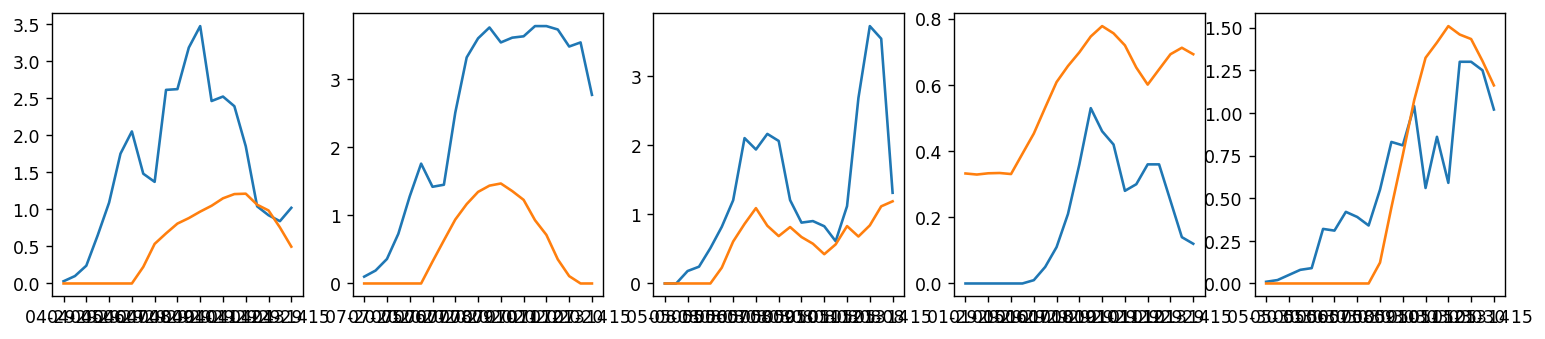

In [29]:
fig, axs = plt.subplots(1,5, figsize=(15,3), dpi=125)

for i in range(5):
    random_day = pd.to_datetime(np.random.choice(charge_pred_df.index.date))
    random_df = charge_pred_df[charge_pred_df.index.date == random_day]
    axs[i].plot(random_df.pv_actual)
    axs[i].plot(random_df.charge_pred)


In [30]:
#exports
def predict_charge(X, model):
    """
    Given a fitted PV forecast model and feature array X, get the optimal charge profile. 
    """
    pv_pred = pd.Series(model.predict(X), index=X.index)    
    charge_pred = charge.construct_charge_s(pv_pred)
    charge_pred = charge.post_pred_charge_proc_func(charge_pred)
        
    return pd.Series(charge_pred, index=X.index)

In [36]:
model = LinearRegression()
model.fit(X_train, y_train)
pv_pred = model.predict(X_test)

charge_pred = predict_charge(X_test, model)

charge_pred_df = pd.DataFrame({'charge_pred': charge_pred,
              'pv_pred': pv_pred,
              'pv_actual': y_test})

solar_exploit_pct = 100*charge_pred_df.groupby(charge_pred_df.index.date).apply(prop_max_solar_df)

print("Held out solar exploit: {:.2f}%".format(solar_exploit_pct.mean(), ))
print("Held out solar exploit (std): {:.2f}".format(solar_exploit_pct.std(), ))


Held out solar exploit: 93.98%
Held out solar exploit (std): 8.19


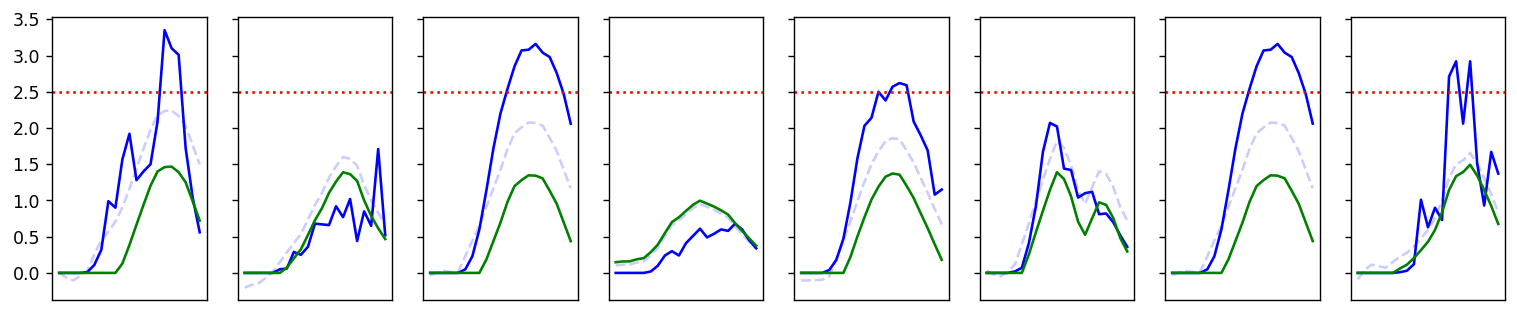

In [37]:
N=8

fig, axs = plt.subplots(1,N, figsize=(15,3), dpi=125, sharey=True)

for i in range(N):
    random_day = pd.to_datetime(np.random.choice(charge_pred_df.index.date, replace=True))
    random_df = charge_pred_df[charge_pred_df.index.date == random_day]
    
    axs[i].plot(random_df.pv_actual, c='b', alpha=1)
    axs[i].plot(random_df.pv_pred, c='b', linestyle='--', alpha=0.2)
    axs[i].plot(random_df.charge_pred, c='g')
    axs[i].axhline(2.5, c='r', linestyle=':')
    axs[i].set_xticks([])



In [39]:
## X, y = prepare_training_input_data(intermediate_data_dir)

start_of_test_period = '2019-02-04'

X_train, X_test = get_train_test(X, start_of_test_period)
y_train, y_test = get_train_test(y, start_of_test_period)

charging_datetimes = charge.extract_charging_datetimes(X_train)
solar_exploit_scorer = construct_solar_exploit_calculator(solar_profile=y, 
                                                            charging_datetimes=charging_datetimes, 
                                                            scorer=True)
groups = charging_datetimes.date

pipeline = Pipeline([
    ('pandas_RF', utils.PandasRandomForestRegressor())
])

search_spaces = {
        'pandas_RF__min_samples_leaf': Integer(1, 20, 'uniform'),
        'pandas_RF__criterion': Categorical(['mse', 'mae']),
        'pandas_RF__n_estimators': Integer(10, 150, 'uniform'),
        'pandas_RF__max_features': Categorical(['auto', 'sqrt']),
        'pandas_RF__max_depth': Integer(5, 200, 'uniform'),
        'pandas_RF__min_samples_split': Integer(2, 10, 'uniform'),
        'pandas_RF__min_samples_leaf': Integer(1, 4, 'uniform'),
        'pandas_RF__bootstrap': Categorical([True, False])
}

opt = utils.BayesSearchCV(
    pipeline,
    search_spaces,
    n_iter=10,
    verbose=1,
    cv=4, 
    scoring=solar_exploit_scorer,
    n_jobs=-1
)

fit_BayesSearchCV = False

if fit_BayesSearchCV == True:
    opt.fit(X_train, y_train, groups=groups)

    print(f'validation score: {opt.best_score_}')
    print(f'held out score: {opt.score(X_test, y_test)}')
    print(f'best params: {opt.best_params_}')

    _ = plot_objective(opt.optimizer_results_[0])
    plt.show()

In [40]:
#exports
def fit_and_save_pv_model(X, y, pv_model_fp, model_class=LinearRegression, **model_params):
    model = model_class(**model_params)
    model.fit(X, y)
    
    with open(pv_model_fp, 'wb') as fp:
        joblib.dump(model, fp)
        
    return

In [8]:
#exports
def optimise_test_charge_profile(raw_data_dir, intermediate_data_dir, pv_model_fp, test_start_date=None, test_end_date=None, start_time='08:00', end_time='23:59'):
    df_features = charge.prepare_test_feature_data(raw_data_dir, intermediate_data_dir, test_start_date=test_start_date, test_end_date=test_end_date, start_time=start_time, end_time=end_time)
    charging_datetimes = charge.extract_charging_datetimes(df_features)
    X_test = df_features.loc[charging_datetimes]
    
    model = discharge.load_trained_model(pv_model_fp)
    charge_profile = predict_charge(X_test, model)
    
    s_charge_profile = pd.Series(charge_profile, index=charging_datetimes)
    s_charge_profile = s_charge_profile.reindex(df_features.index).fillna(0)
    s_charge_profile = charge.post_pred_charge_proc_func(s_charge_profile)
    
    assert charge.charge_is_valid(s_charge_profile), "Charging profile is invalid"
    
    return s_charge_profile

<AxesSubplot:xlabel='datetime'>

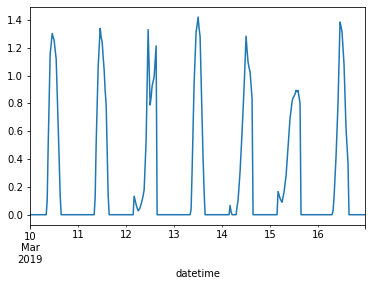

In [43]:
pv_model_fp = '../models/pv_model.sav'
s_charge_profile = optimise_latest_test_charge_profile(raw_data_dir, intermediate_data_dir, pv_model_fp)

s_charge_profile.plot()

<br>

Finally we'll export the relevant code to our `batopt` module

In [9]:
#hide
from nbdev.export import notebook2script
    
notebook2script()

Converted 00-utilities.ipynb.
Converted 01-retrieval.ipynb.
Converted 02-cleaning.ipynb.
Converted 03-charging.ipynb.
Converted 04-discharging.ipynb.
Converted 05-constraints.ipynb.
Converted 06-tuning.ipynb.
Converted 07-charging-nn.ipynb.
Converted 08-pv-forecast.ipynb.
Converted 09-christmas.ipynb.
Converted 09-pipeline.ipynb.
Converted 10-pipeline.ipynb.
